## Training and evaluation of best models for signal background separation

In [5]:
import uproot
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from tabulate import tabulate
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
muons_scale = 5825876.1 / 9817299.000
atm_nu_scale = 5825876.1
cosmic_nu_scale = 5825876.1

In [2]:
#obtain data from root file
netr = 'Train/forBDT_Train_ML_All_NuAnu_ARCA19_ARCA21_v8.1_First_Up_WR.root'
muon = 'Train/forBDT_Train_ML_All_Muons_ARCA19_ARCA21_v8.1_First_Up_br.root'
netr = uproot.open(netr)['ProcessedEvents_forBDT']
muon = uproot.open(muon)['ProcessedEvents_forBDT;1']
#make list of variables to use
vrs = "downsol logbeta0 normdlik ratio_lower_nhits max_diff_sol TrLengthIT_2 ratio110 float_num_triggered_lines \
min_zen_sol num_of_good_sol float_num_cherenkov_doms best_trk_pos_z jlik best_trk_dir_shower_z".split(' ')

#crate one dataframe for all vars 
df_n = netr[vrs[0]].arrays(library = 'pd')
for v in vrs[1:]:
    df_n = pd.concat([df_n, netr[v].arrays(library = 'pd') ], axis=1, join='inner')
df_m = muon[vrs[0]].arrays(library = 'pd')
for v in vrs[1:]:
    df_m = pd.concat([df_m, muon[v].arrays(library = 'pd') ], axis=1, join='inner')

#ground trouth for netr and muons
yn = pd.DataFrame({'id': len(df_n.index)*[1]})
ym = pd.DataFrame({'id': len(df_m.index)*[0]})
#make one shuffled df
df_n = pd.concat([df_n, yn], axis=1, join='inner')
df_m = pd.concat([df_m, ym], axis=1, join='inner')


#df balanced dataset
df_n1 = df_n.sample(1 * len(df_m.index))
df1 = pd.concat([df_n1, df_m]).sample(frac=1)
print(df_n1.shape, df_m.shape, df1.shape)

#df_ ibalnced dataset
df_n2 = df_n.sample(10 * len(df_m.index))
df_ = pd.concat([df_n2, df_m]).sample(frac=1)
print(df_n2.shape, df_m.shape, df_.shape)

### Split to train and test set
#1-1 dataset
X_train, X_test, y_train, y_test = train_test_split(df1.iloc[:,:-1], df1['id'], test_size=0.2, random_state=42)
#10-1 dataset
X_train_, X_test_, y_train_, y_test_ = train_test_split(df_.iloc[:,:-1], df_['id'], test_size=0.2, random_state=42)

(5199, 15) (5199, 15) (10398, 15)
(51990, 15) (5199, 15) (57189, 15)


In [4]:
## load evaluation set 
muon_ev = 'Evaluation/forBDT_mine_muons_All_ARCA21_v8.1_bdt_branch.root'
netr_ev = "Evaluation/forBDT_mine_a-nu_Mu_CC_All_ARCA21_v8.1_bdt_branch.root" #'Evaluation/forBDT_mine_a-nu_FLAVOURS_combined_all_ARCA21_v8.1_bdt_branch.root'
muon_ev = uproot.open(muon_ev)['ProcessedEvents_forBDT;1']
netr_ev = uproot.open(netr_ev)['ProcessedEvents_forBDT;54']
muons_scale = 5825876.1 / 9817299.000
atm_nu_scale = 5825876.1
cosmic_nu_scale = 5825876.1
df_n_eval = netr_ev[vrs[0]].arrays(library = 'pd')
for v in vrs[1:]:
    df_n_eval = pd.concat([df_n_eval, netr_ev[v].arrays(library = 'pd') ], axis=1, join='inner')
df_m_eval = muon_ev[vrs[0]].arrays(library = 'pd')
for v in vrs[1:]:
    df_m_eval = pd.concat([df_m_eval, muon_ev[v].arrays(library = 'pd') ], axis=1, join='inner')

In [6]:
#obtain weights
ice_n = netr_ev['w3ice'].arrays(library='np')['w3ice']
atm_n = netr_ev['w3atm'].arrays(library='np')['w3atm']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric='map',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)


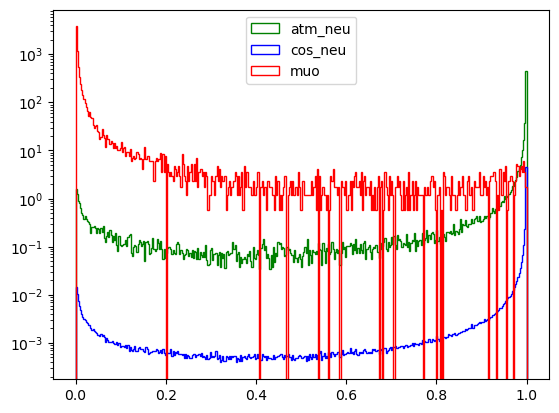

+----+--------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|    | cut    |   muons remain |   muons rejected |   muons rej per |   neutrinos rem |   neutr rej |   efficiency |   purity |
+====+========+================+==================+=================+=================+=============+==============+==========+
|  0 | 395 sc |       19.5832  |          8350.74 |        0.99766  |         5.04911 |    0.654852 |     0.885193 | 0.964098 |
+----+--------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|  1 | 396 sc |       14.8357  |          8355.49 |        0.998228 |         5.00155 |    0.702413 |     0.876855 | 0.972189 |
+----+--------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|  2 | 397 sc |       11.2752  |          8359.05 |        0.998653 |         4.93521 |    0.768752 |   

In [7]:
### xgb model training, testing
#1
model_xgb = XGBClassifier(max_depth = 4, n_estimators=60,  eta=0.2, eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5)
#2
#model_xgb = XGBClassifier(max_depth = 4, n_estimators=30,  eta=0.2, eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5)
#3
#model_xgb = XGBClassifier(max_depth = 4, n_estimators=40,  eta=0.2, eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5)
#4
#model_xgb = XGBClassifier(max_depth = 4, n_estimators=50,  eta=0.2, eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5)
  
print(model_xgb.fit(X_train_, y_train_))
#print(model_xgb.fit(X_train, y_train)) only for 1st model
prob_eval_n = model_xgb.predict_proba(df_n_eval)
prob_eval_m = model_xgb.predict_proba(df_m_eval)
n1, x1, _ = plt.hist(prob_eval_n[:,1], 400,range=(0,1), log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2, x2, _ =plt.hist(prob_eval_n[:,1], 400, range=(0,1), log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3, x3, _ =plt.hist(prob_eval_m[:,1], 400, range=(0,1), log=True, weights=[muons_scale]*prob_eval_m[:,1].shape[0], histtype=u'step', label='muo', color='r')
plt.legend(loc='upper center')
plt.show()
ccc = [395,396, 397, 398, 399]
col_names = ['cut', 'muons remain', 'muons rejected', 'muons rej per', 'neutrinos rem', 'neutr rej', 'efficiency', 'purity']

data = []
for cc in ccc:
        data.append((str(cc) + ' sc', sum(n3[cc:]), sum(n3[:cc]), sum(n3[:cc])/sum(n3) , sum(n2[cc:]), sum(n2[:cc]), sum(n2[cc:])/sum( n2),
                sum(n2[cc:] + n1[cc:])/sum(n1[cc:] + n2[cc:] + n3[cc:])))

print(tabulate(data, headers=col_names, tablefmt="grid", showindex="always"))

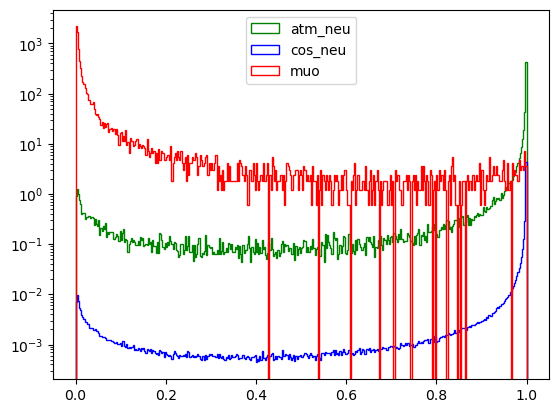

+----+--------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|    | cut    |   muons remain |   muons rejected |   muons rej per |   neutrinos rem |   neutr rej |   efficiency |   purity |
+====+========+================+==================+=================+=================+=============+==============+==========+
|  0 | 394 sc |       23.7372  |          8346.59 |        0.997164 |         5.02457 |    0.679386 |     0.880892 | 0.956346 |
+----+--------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|  1 | 395 sc |       20.77    |          8349.55 |        0.997519 |         4.98247 |    0.721491 |     0.873511 | 0.961129 |
+----+--------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|  2 | 396 sc |       17.2095  |          8353.12 |        0.997944 |         4.92737 |    0.776586 |   

In [8]:
from catboost import CatBoostClassifier
model_ctb = CatBoostClassifier(
    iterations=11, 
    learning_rate=0.8, 
    loss_function='CrossEntropy'
)

model_ctb.fit(X_train_, y_train_, 
        verbose=False
)

prob_eval_n_c = model_ctb.predict_proba(df_n_eval)
prob_eval_m_c = model_ctb.predict_proba(df_m_eval)
n1c, x1c, _ = plt.hist(prob_eval_n_c[:,1], 400,range=(0,1), log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2c, x2c, _ =plt.hist(prob_eval_n_c[:,1], 400, range=(0,1), log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3c, x3c, _ =plt.hist(prob_eval_m_c[:,1], 400, range=(0,1), log=True, weights=[muons_scale]*prob_eval_m_c[:,1].shape[0], histtype=u'step', label='muo', color='r')
plt.legend(loc='upper center')
plt.show()

from tabulate import tabulate
ccc = [394, 395,396, 397, 398, 399]
col_names = ['cut', 'muons remain', 'muons rejected', 'muons rej per', 'neutrinos rem', 'neutr rej', 'efficiency', 'purity']
data = []
for cc in ccc:
        data.append((str(cc) + ' sc', sum(n3c[cc:]), sum(n3c[:cc]), sum(n3c[:cc])/sum(n3c) , sum(n2c[cc:]), sum(n2c[:cc]), sum(n2c[cc:])/sum( n2c),
                sum(n2c[cc:] + n1c[cc:])/sum(n1c[cc:] + n2c[cc:] + n3c[cc:])))

print(tabulate(data, headers=col_names, tablefmt="grid", showindex="always"))